# What kind of curve (or model) should I fit to my percentage data?


from https://stats.stackexchange.com/q/418584/17060

In [1]:
from io import StringIO

import numpy as np
import pandas as pd

import pystan
import arviz

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import seaborn as sns
sns.set(style='ticks')

In [3]:
raw_data = """Subsample   Virus   Genome_cov  Copies_per_uL
1   S1.1_RRAV   RRAV    100 92500
2   S1.2_RRAV   RRAV    100 95900
3   S1.3_RRAV   RRAV    100 92900
4   S2.1_RRAV   RRAV    100 4049.54
5   S2.2_RRAV   RRAV    96.9935 3809
6   S2.3_RRAV   RRAV    94.5054 3695.06
7   S3.1_RRAV   RRAV    3.7235  86.37
8   S3.2_RRAV   RRAV    11.8186 84.2
9   S3.3_RRAV   RRAV    11.0929 95.2
10  S4.1_RRAV   RRAV    0   2.12
11  S4.2_RRAV   RRAV    5.0799  2.71
12  S4.3_RRAV   RRAV    0   2.39
13  S5.1_RRAV   RRAV    4.9503  0.16
14  S5.2_RRAV   RRAV    0   0.08
15  S5.3_RRAV   RRAV    4.4147  0.08
16  S1.1_UMAV   UMAV    5.7666  1.38
17  S1.2_UMAV   UMAV    26.0379 1.72
18  S1.3_UMAV   UMAV    7.4128  2.52
19  S2.1_UMAV   UMAV    21.172  31.06
20  S2.2_UMAV   UMAV    16.1663 29.87
21  S2.3_UMAV   UMAV    9.121   32.82
22  S3.1_UMAV   UMAV    92.903  627.24
23  S3.2_UMAV   UMAV    83.0314 615.36
24  S3.3_UMAV   UMAV    90.3458 632.67
25  S4.1_UMAV   UMAV    98.6696 11180
26  S4.2_UMAV   UMAV    98.8405 12720
27  S4.3_UMAV   UMAV    98.7939 8680
28  S5.1_UMAV   UMAV    98.6489 318200
29  S5.2_UMAV   UMAV    99.1303 346100
30  S5.3_UMAV   UMAV    98.8767 345100
"""

df = pd.read_table(StringIO(raw_data), delim_whitespace=True)
df.columns = ['subsample', 'virus', 'coverage', 'copies']
df.coverage /= 100
df

,subsample,virus,coverage,copies
1,S1.1_RRAV,RRAV,1.000000,92500.00
2,S1.2_RRAV,RRAV,1.000000,95900.00
3,S1.3_RRAV,RRAV,1.000000,92900.00
4,S2.1_RRAV,RRAV,1.000000,4049.54
5,S2.2_RRAV,RRAV,0.969935,3809.00
6,S2.3_RRAV,RRAV,0.945054,3695.06
7,S3.1_RRAV,RRAV,0.037235,86.37
8,S3.2_RRAV,RRAV,0.118186,84.20
9,S3.3_RRAV,RRAV,0.110929,95.20
10,S4.1_RRAV,RRAV,0.000000,2.12


plot the data and show the sigmoid function we're going to be using. hard code parameters for now to make sure we can get something reasonable

the parameters are:

 * `alpha` defines the "midpoint" of the sigmoid curve, in units of natural logs.  larger values mean more copies needed to get the same coverage.  i.e. 50% coverage is at `np.exp(alpha)`
 * `beta` determines the slope of the curve, larger values mean coverage changes more rapidly with number of copies, negative values are possible meaning coverage goes down as copies increases

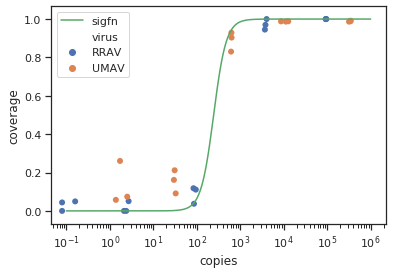

In [5]:
def sigfn(x, alpha, beta):
    return 1 / (1 + np.exp(-(x - alpha) * beta))

x = np.logspace(-1, 6, 201)
plt.plot(x, sigfn(np.log(x), 5.5, 3), label='sigfn', color='C2')

sns.scatterplot(df.copies, df.coverage, hue=df.virus, edgecolor='none')
plt.xscale('log')

first we start with a simple (barely bayesian) model.  no concept of viral species yet, just make sure we can fit something

In [6]:
code = """
data {
    int<lower=1> N;  // number of rows
    vector[N] log_copies;
    vector<lower=0,upper=1>[N] coverage;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    vector[N] mu;
    mu = 1 ./ (1 + exp(-(log_copies - alpha) * beta));

    sigma ~ cauchy(0, 0.1);
    alpha ~ normal(0, 5);
    beta ~ normal(0, 5);
    
    coverage ~ normal(mu, sigma);
}
"""

model1 = pystan.StanModel(model_code=code, extra_compile_args=['-O1'])

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_25353c58399df2775c87c381e831c225 NOW.


perform MCMC sampling on the model and display a summary of the fit, making sure we can run Stan and it gives us something back we expect

I've used the mean of these estimates in the plot above, but note the variance on `beta` is large.  95% CI is (1.5, 8.5) which is saying the data is consistant with a wide variety of different slopes, but that they'd have to be relatively steep

Inference for Stan model: anon_model_25353c58399df2775c87c381e831c225.
4 chains, each with iter=10000; warmup=5000; thin=10; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   5.51  6.0e-3   0.26   4.96   5.36   5.49   5.64   6.12   1849    1.0
beta    2.89    0.04   1.71   1.55   1.98   2.32   2.95   8.08   1698    1.0
sigma   0.08  2.7e-4   0.01   0.06   0.07   0.08   0.09    0.1   1790    1.0
lp__   57.12    0.04   1.76   52.9   56.1  57.58  58.51  59.19   1647    1.0

Samples were drawn using NUTS at Thu Jul 25 15:15:45 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

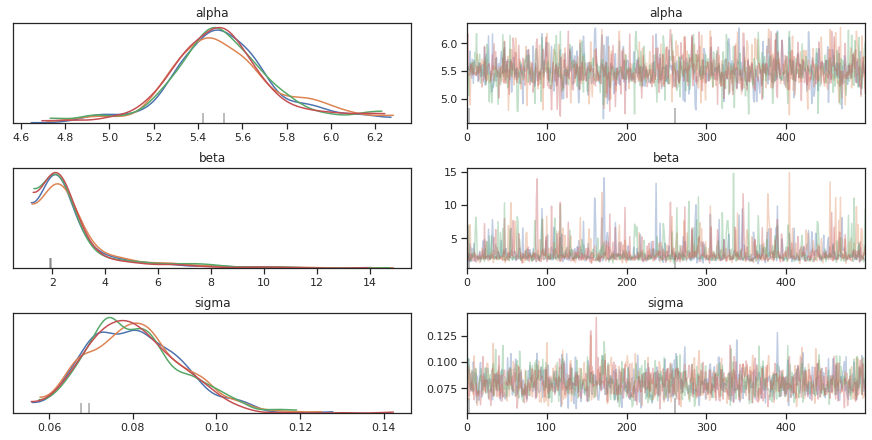

In [7]:
fit = model1.sampling(data=dict(
    N=len(df),
    log_copies=np.log(df.copies),
    coverage=df.coverage,
), iter=10000, chains=4, thin=10)

arviz.plot_trace(fit)

fit

I've now played a bit more and extended the model to allow multiple species.  the parameters `alpha` and `beta` are allowed to vary by species, but have a hierchial prior on them that tries to keep them similar.  other parameters should be obvious:

 * `sigma` is the standard deviation of the residual error
 * `alpha_mu` and `alpha_sd` are hierarchical priors on `alpha`
 * `beta_mu` and `beta_sd` are the same for the `beta`s

In [9]:
code = """
data {
    int<lower=1> N;  // number of rows
    int<lower=1> K;  // number of species
    vector[N] log_copies;
    vector<lower=0,upper=1>[N] coverage;
    int<lower=1,upper=K> species[N];
}
parameters {
    vector[K] alpha;
    vector[K] beta;
    real<lower=0> sigma;

    real alpha_mu;
    real<lower=0> alpha_sd;
    real beta_mu;
    real<lower=0> beta_sd;
}
model {
    vector[N] mu;

    alpha_mu ~ normal(5, 5);
    alpha_sd ~ cauchy(0, 0.1);

    beta_mu ~ normal(1, 2);
    beta_sd ~ cauchy(0, 0.1);

    alpha ~ normal(alpha_mu, alpha_sd);
    beta ~ normal(beta_mu, beta_sd);

    for (i in 1:N) {
        mu[i] = 1 / (1 + exp(-(log_copies[i] - alpha[species[i]]) * beta[species[i]]));
    }

    sigma ~ cauchy(0, 0.1);

    coverage ~ normal(mu, sigma);
}
"""

model2 = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6d2641f8232220ac62d73a882c586f9e NOW.


running this is a bit more fiddly, but should be relatively obvious

Inference for Stan model: anon_model_6d2641f8232220ac62d73a882c586f9e.
4 chains, each with iter=10000; warmup=5000; thin=10; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   5.75    0.01    0.4   4.92    5.5   5.79   6.04   6.46   1039    1.0
alpha[2]   4.89  8.2e-3   0.26   4.44   4.74   4.87   5.02   5.52    976    1.0
beta[1]    2.03    0.05   1.25   1.17   1.37    1.6   2.14    5.3    718    1.0
beta[2]    1.42    0.02   0.39   1.04   1.23   1.33   1.49   2.45    634   1.01
sigma      0.07  3.3e-4 9.7e-3   0.05   0.06   0.06   0.07   0.09    862   1.01
alpha_mu   5.31    0.03   0.81   3.85    5.0   5.26   5.61   6.78    947    1.0
alpha_sd   0.73    0.03   0.98   0.05   0.28   0.52   0.87    2.8   1104    1.0
beta_mu    1.64    0.02   0.65   0.86   1.29   1.48   1.83   3.36    930   1.01
beta_sd    0.55    0.04   1.32   0.01   0.07   0.17   0.45   3.55   1060    1.0
lp__      

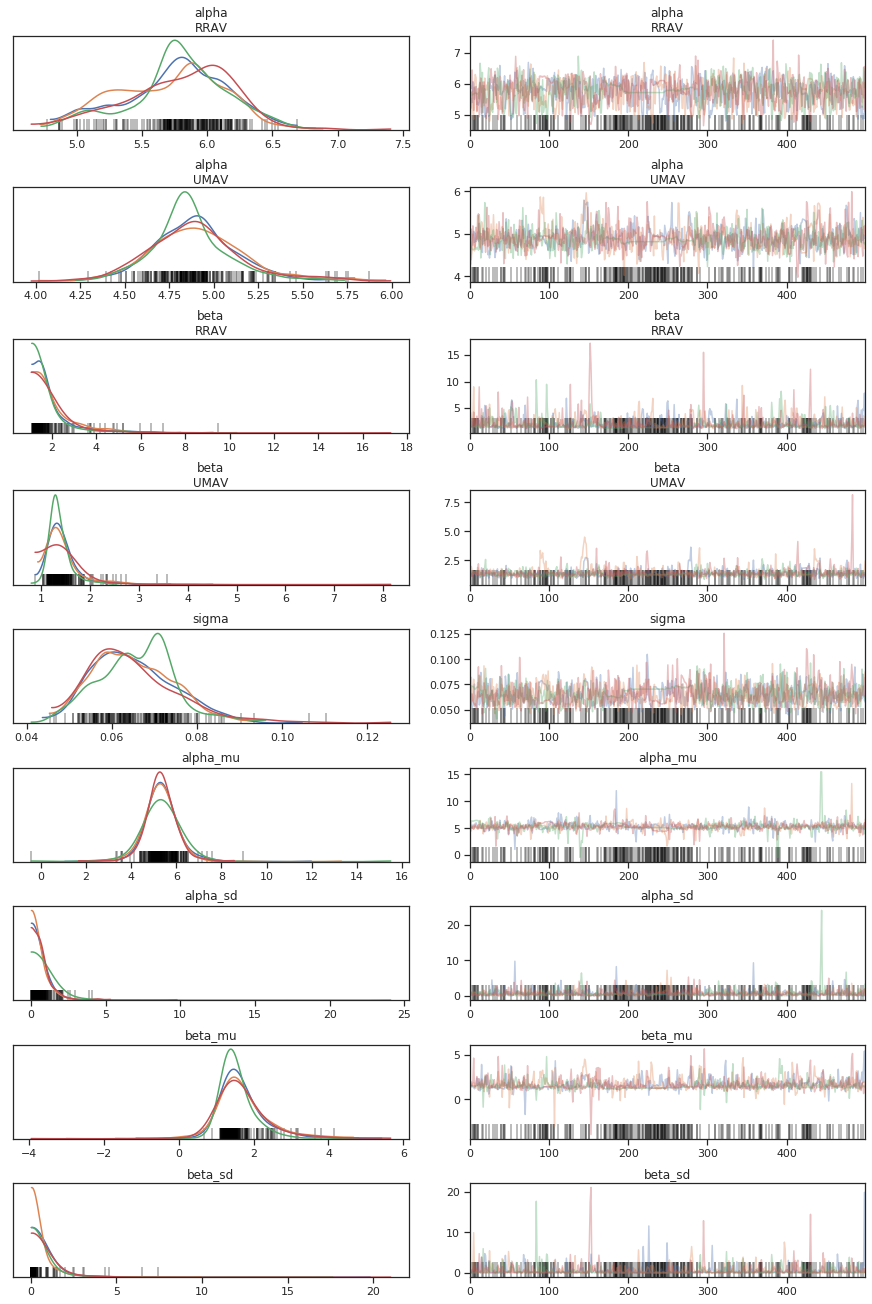

In [15]:
virus_f, virus_cat = df.virus.factorize()

fit = model2.sampling(data=dict(
    N=len(df),
    K=len(virus_cat),
    log_copies=np.log(df.copies),
    coverage=df.coverage,
    species=virus_f + 1, # + 1 because Stan does indexing from 1
), iter=10000, chains=4, thin=10)

viz = arviz.from_pystan(
    fit,
    coords=dict(virus=virus_cat),
    dims=dict(alpha=['virus'], beta=['virus']),
)
arviz.plot_trace(viz)

fit

to convince us it's doing something useful, we can plot some samples from the posterior with the data

we can see that `UMAV` is much better constrained by the data, while the dichotomy of `RRAV`'s coverage (i.e. they're basically either 0% or 100% coverage) means the slope is relatively unconstrained.

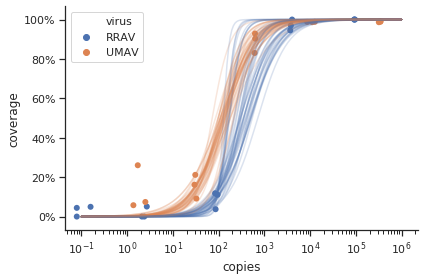

In [16]:
chain_alpha, chain_beta = fit.extract(('alpha', 'beta')).values()

x = np.logspace(-1, 6, 201)

for i in np.random.randint(0, len(chain_alpha)-1, 40):
    plt.plot(x, sigfn(np.log(x), chain_alpha[i,0], chain_beta[i,0]), c='C0', alpha=0.2)
    plt.plot(x, sigfn(np.log(x), chain_alpha[i,1], chain_beta[i,1]), c='C1', alpha=0.2)

ax = sns.scatterplot(df.copies, df.coverage, hue=df.virus, edgecolor='none')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.xscale('log')
sns.despine()
plt.tight_layout()
plt.savefig('fit.png', dpi=120)

another way to look at this is to see how `alpha` and `beta` interact.  note that we are free to transform the samples into values/units we might care about

in this case I assume you are likely to do more tests and hence might want to know how many viral copies are needed to ensure reasonable coverage, arbitrarily picking 95% coverage.  you could change `pi` to 5 if you want >99%, but be aware that the further you push this the less certain the estimates

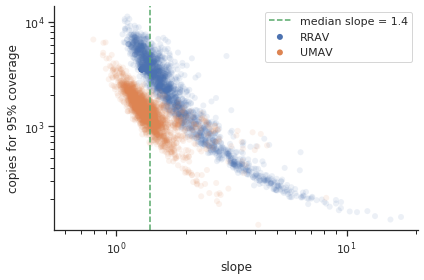

In [17]:
chain_alpha, chain_beta = fit.extract(('alpha', 'beta')).values()

# invert sigmoid to find the number of copies that give ~95% coverage
threshold = np.exp(chain_alpha + np.pi/chain_beta)

for i, cat in enumerate(virus_cat):
    plt.scatter(
        chain_beta[:, i], threshold[:, i], label=cat,
        alpha=0.1, edgecolors='none',
    )

plt.xlabel('slope')
plt.ylabel('copies for 95% coverage')
plt.xscale('log')
plt.yscale('log')

# horizontal line through the median slope
beta_median = round(np.median(chain_beta), 1)
plt.axvline(beta_median, ls='--', color='C2', label=f'median slope = {beta_median}')

legend = plt.legend()
for lh in legend.legendHandles: 
    lh.set_alpha(1)

sns.despine()

plt.tight_layout()
plt.savefig('fit_alpha_vs_beta', dpi=120)